In [1]:
%pylab inline
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 15
import hmf
import astropy.io.ascii as ascii
import cosmology
cosmo=cosmology.Cosmo(h=1.,omega_m=0.315)
from scipy.interpolate import griddata
if True:
    detfname='/work/xiangchong.li/work/massMapSparse/sim/planck-cosmo/nfw-halos/haloDet-NFW-lbd50-nu15.csv'
    figMsDir='/work/xiangchong.li/work/massMapSparse/sim/plot/'
else:
    detfname='/home/xiangchong/work/gw_ipmu/work/massMapSparse/sim/planck-cosmo/nfw-halos/haloDet-NFW-lbd50-nu15.csv'
    figMsDir='/home/xiangchong/.local/code/massMap_Private/doc/paper_ms_method_HSCY1/'
data=ascii.read(detfname)

Populating the interactive namespace from numpy and matplotlib


In [2]:
hmfmod='Tinker08'#'ST'#
mf = hmf.MassFunction(Mmin=13.5,Mmax=15.2,dlog10m=0.1,hmf_model=hmfmod,takahashi=True,sigma_8=0.811,n=0.965)
mf.update(cosmo_params={"Om0":0.315,"H0":67.4})
print(mf.cosmo)
print(mf.hmf_model)

FlatLambdaCDM(name="Planck15", H0=67.4 km / (Mpc s), Om0=0.315, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
<class 'hmf.mass_function.fitting_functions.Tinker08'>


In [3]:
nsamp=20
zbound=np.linspace(0.01,0.70,nsamp+1)
zmin=zbound[:-1]
zmax=zbound[1:]
zave=(zmin+zmax)/2.

zlist=[]
mlist=[]
nlist=[]
for iz in range(nsamp):
    z=zave[iz]
    mf.update(z=z)
    v=cosmo.V(zmin[iz],zmax[iz])*np.pi**2./180.**2./4./np.pi
    print(v)
    mass_func = mf.dndlog10m
    logm = np.log10(mf.m)
    nm=len(logm)
    for i in range(nm):
        zlist.append(z)
        mlist.append(logm[i])
        nlist.append(mass_func[i]*v)
zlist=np.array(zlist)
mlist=np.array(mlist)
nlist=np.array(nlist)*mf.dlog10m

230.78696612571215
1040.2655496065165
2407.514956566999
4269.6987270224
6566.291036211959
9239.550146141059
12234.888823470437
15501.145564849548
18990.76341144468
22659.88522827525
26468.37563008017
30379.78035122114
34361.23390133965
38383.32594686929
42419.936132781455
46448.04611929193
50447.5365489026
54400.97555647173
58293.40434767131
62112.12434144389


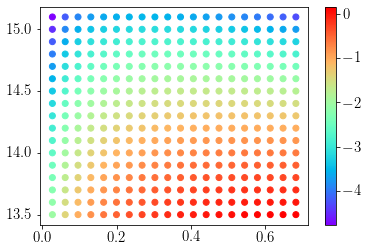

In [4]:
plt.scatter(zlist,mlist,c=np.log10(nlist),cmap='rainbow')
plt.colorbar()

In [5]:
print(np.sum(nlist))

52.85380689181602


In [6]:
mask=mlist<13.9
print(nlist[mask])

[0.00927826 0.00728487 0.00567335 0.00437773 0.00333834 0.04103243
 0.03212204 0.024933   0.01916674 0.01455385 0.09307617 0.0726407
 0.05618804 0.04302421 0.03252465 0.16161871 0.12573122 0.09690302
 0.07389792 0.0556063  0.24308537 0.18847951 0.14471914 0.10989462
 0.08229653 0.33414575 0.25818943 0.19747162 0.14929321 0.11124463
 0.4317354  0.33239948 0.25320211 0.19055323 0.14125679 0.53307153
 0.40889418 0.31016632 0.2323195  0.17129807 0.63566231 0.48570997
 0.36683698 0.27342249 0.20049066 0.73731015 0.56113578 0.42190226
 0.312875   0.22810928 0.83611076 0.63371023 0.47426128 0.34986638
 0.25357439 0.93044484 0.70221235 0.52301429 0.38375236 0.27644198
 1.01896903 0.76565203 0.56745268 0.41404492 0.29639354 1.10060123
 0.8232556  0.6070451  0.440399   0.31322359 1.1745038  0.87444996
 0.64142243 0.4625986  0.32682688 1.24006608 0.91884617 0.67036268
 0.48054278 0.33718584 1.29688256 0.9562197  0.69377309 0.49422988
 0.34435675 1.34473379 0.98649313 0.7116747  0.50374379 0.34845

In [7]:
zdet=data['zh']
log10mDet=data['log10_M200']
det=data['detRat']

In [8]:
def grid_interpolate_2d(x, y, z, eval_x, eval_y):
    """
    This is a utility for interpolating a 2D function z(x, y) linearly to values
    (x, y) = (eval_x, eval_y), but also enabling extrapolation beyond the (x, y)
    bounds using the nearest neighbor method.
    """
    result = griddata((x, y), z, (eval_x, eval_y), method='linear')
    nn_result = griddata((x, y), z, (eval_x, eval_y), method='nearest')
    mask = np.isnan(result)
    result[mask] = nn_result[mask]
    return result

detEst=grid_interpolate_2d(zdet,log10mDet,det, zlist, mlist)

/work/xiangchong.li/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


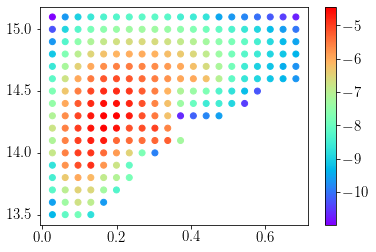

In [9]:
plt.scatter(zlist,mlist,c=log(nlist*detEst),cmap='rainbow')
plt.colorbar()

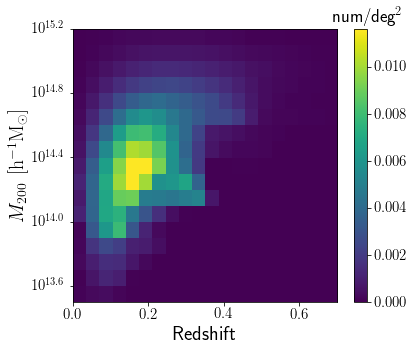

In [20]:
sp=(len(zave),len(zlist)//len(zave))
plt.figure(figsize=(6,5))
#plt.title('Detection Number Density')
plt.imshow(np.transpose((nlist*detEst).reshape(sp)),aspect='auto',origin='lower',extent=(0,0.7,13.5,15.2))
plt.xlabel('Redshift',fontsize=20)
plt.ylabel(r'$M_{200}\>\, [\rm{h^{-1}M_{\odot}}]$',fontsize=20)
plt.yticks((13.6,14.0,14.4,14.8,15.2),\
  (r'$10^{13.6}$',r'$10^{14.0}$',r'$10^{14.4}$',r'$10^{14.8}$',r'$10^{15.2}$'))
clb=plt.colorbar()
clb.set_label(r'num/deg$^{2}$', labelpad=-40, y=1.08, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(figMsDir,'detNum_zm.pdf'))

In [21]:
np.sum(nlist*detEst)

0.4903633179214362

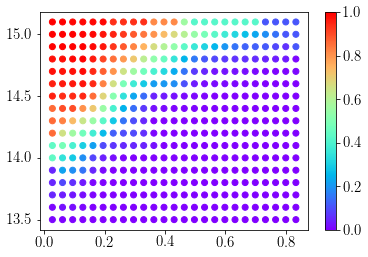

In [12]:
plt.scatter(zlist,mlist,c=detEst,cmap='rainbow')
plt.colorbar()